<a href="https://colab.research.google.com/github/midway-official/fluentmeshIO/blob/main/Shimakaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import re

def plot_faces(points, faces, zone_ids):
    # 确保 zone_ids 是一个列表
    if isinstance(zone_ids, int):
        zone_ids = [zone_ids]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 存储绘制的面
    faces_to_plot = []

    for face in faces:
        if face[6] in zone_ids:
            n0, n1, n2, n3 = face[:4]
            # 获取每个点的坐标 id从1开始 故索引减1
            p0 = points[n0-1]
            p1 = points[n1-1]
            p2 = points[n2-1]
            p3 = points[n3-1]
            # 为四边形创建面
            face_vertices = np.array([p0, p1, p2, p3, p0])
            faces_to_plot.append(face_vertices)

    # 使用 Poly3DCollection 绘制面
    poly3d = Poly3DCollection(faces_to_plot, edgecolor='k', linewidths=0.5, alpha=0.5)
    ax.add_collection3d(poly3d)

    # 设置坐标轴范围
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # 自动调整坐标轴范围
    x, y, z = zip(*[point for point in points])
    ax.set_xlim(min(x), max(x))
    ax.set_ylim(min(y), max(y))
    ax.set_zlim(min(z), max(z))

    plt.show()

In [7]:
def n_head_to_array(input_str):

    elements = input_str.split()


    if len(elements) < 5:
        raise ValueError("输入cells/nodes总述必须包含至少6个要点")

    result_array = [
        int(elements[0]),         # zoneid
        int(elements[1]),         # 第一个索引
        int(elements[2], 16),     # 第二个索引，十六进制转十进制
        int(elements[3]),         # 类型/bc type
        int(elements[4]),         # 维度/面type

    ]

    return result_array

In [8]:
def f_head_to_array(input_str):

    elements = input_str.split()


    if len(elements) < 5:
        raise ValueError("输入cells/nodes总述必须包含至少6个要点")

    result_array = [
        int(elements[0], 16),         # zoneid
        int(elements[1], 16),     # 第一个索引，十六进制转十进制
        int(elements[2], 16),     # 第二个索引，十六进制转十进制
        int(elements[3], 16),     # 类型/bc type,十六进制转十进制
        int(elements[4]),         # 维度/面type

    ]

    return result_array

In [9]:
def nodes_coordinate_to_array(input_str,dim):

    elements = input_str.split()

    # 检查 维度
    if dim not in [2, 3]:
        raise ValueError("mesh维度 必须是 2 或 3")


    if len(elements) % dim != 0:
        raise ValueError("元素数量必须是 维度 的倍数")

    # 将元素按 维度个一组分组，并将每个元素转换为浮点数
    coordinate_array = [[float(num) for num in elements[i:i + dim]] for i in range(0, len(elements), dim)]

    return coordinate_array


In [10]:
def face_thread_to_array(input_str,dim):

    elements = input_str.split()



    # 将元素按 维度个一组分组，并将每个元素转换为整数
    coordinate_array = [[int(num,16) for num in elements[i:i + dim]] for i in range(0, len(elements), dim)]

    return coordinate_array


In [11]:




with open('/content/drive/MyDrive/loader/2.msh', 'r') as file:
    content = file.read()


    # nodes总述字段
    #匹配（10())
    pattern1 = r'\(10\s*\(([^)]+)\)\)'
    nodes_heads = re.findall(pattern1, content)
    for head in nodes_heads:
         nodesOverview=n_head_to_array(head)

    # nodes坐标字段
    # 匹配 (10 ()()) 模式
    pattern2 = r'\(10\s*\(([^)]+)\)\s*\(([\s\S]*?)\)\)'
    nodes_datas_list= re.findall(pattern2, content)

    for match in nodes_datas_list:
        part_info, coordinates = match
        part_info=n_head_to_array(part_info)
        node_data=nodes_coordinate_to_array(coordinates,3)




In [12]:
    # face总述字段
    #匹配（13())
    face=[]
    pattern3 = r'\(13\s*\(([^)]+)\)\)'
    face_heads = re.findall(pattern3, content)
    for head in nodes_heads:
        faceOverview=f_head_to_array(head)

    # face线程字段
    # 匹配 (13 ()()) 模式
    pattern4 = r'\(13\s*\(([^)]+)\)\s*\(([\s\S]*?)\)\)'
    faces_datas0= re.findall(pattern4, content)


    faces_heads =[f_head_to_array(t[0]) for t in faces_datas0]  # 存放面头字段
    faces_thread = [face_thread_to_array(t[1],6) for t in faces_datas0] # 存放面详细组成，线程 面描述字段


    face_head_list = []


    for face in faces_heads:
        zone_id, first_index, last_index, bc_type, face_type = face


        for index in range(first_index, last_index + 1):
        # 将 zone-id、index、bc-type、face-type 加入到面线程列表中
            face_head_list.append([zone_id, index, bc_type, face_type])

    face_thread_list = []


    for sublist in faces_thread:
        for item in sublist:
            face_thread_list.append(item)
#合并
    face_data=[]   #6个整至，面线程数据+ zone_id, first_index, last_index, bc_type, face_type
    for i in range(len(face_head_list)-1):
        face_data.append(face_thread_list[i]+face_head_list[i])


In [38]:


class Mesh:
    def __init__(self, points, faces):

        self.points = points
        self.faces = faces

    def get_point(self, index):
        # 获取点坐标，注意索引从1开始
        return self.points[index - 1]

    def get_face(self, index):
        # 获取面数据，注意索引从1开始
        return self.faces[index - 1]

    def add_point(self, coordinates):
        # 添加点坐标
        self.points.append(coordinates)

    def add_face(self, face_data):
        # 添加面数据
        self.faces.append(face_data)

    def find_faces_by_point_id(self, point_id):
        # 查找指定点 ID 的面数据
        point_id = int(point_id)  #
        faces_with_point = []

        for face in self.faces:
            n0, n1, n2, n3, c0, c1, zone_id, first_index, last_index, bc_type, face_type = face

            # 检查节点 ID 是否在 n0, n1, n2, n3 中
            if point_id in [n0, n1, n2, n3]:
                faces_with_point.append(face)

        return faces_with_point
    def plot_face_in_zone(self,zones):
        plot_faces(self.points,self.faces,zones)
    def __str__(self):
        return f'Points: {self.points}\nFaces: {self.faces}'

In [40]:
mesh0=Mesh(node_data,face_data)

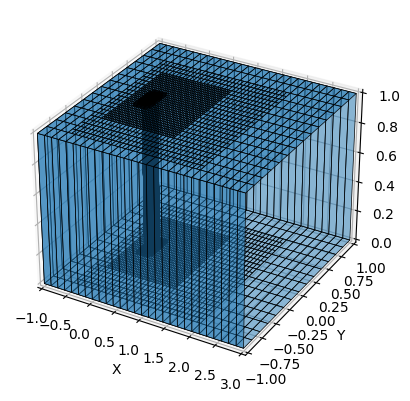

In [43]:
mesh0.plot_face_in_zone([5,6,7,8,9,10])